In [174]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from tifffile import imwrite
import math
import PIL.Image

import sys, os
sys.path.append(os.path.join(sys.path[0], '../tauSWIRcamera')) 
# sys.path.append(os.path.join(sys.path[0], '/home/brunomattos/Documents/Finis-Camera/tauSWIRCamera')) 
from tauSWIRcamera import tauSWIRcamera

plt.rcParams["font.family"] = "Times New Roman"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initialize Camera with Default Settings

In [175]:
hostname = '129.123.5.125'
port = 4000
cam = tauSWIRcamera(hostname, port, "MASTER")
cameraFolder = cam.name
# Print the Priority
cam.setPriority("Integration")
print(cam.getPriority())
print(cam.name)


## START CAMERA SETUP ##
1. Analog mode set to: DISABLED
2. External Sync Mode set to: MASTER
3. AGC set to: MANUAL
3. Brightness Level set to: 0
3. Contrast Level set to: 0
4. Auto-Exposure set to: DISABLED
5. CMOS bit depth set to: 14-BITS
6. Camera Link bit depth set to: 14-BITS
7. Integration mode set to: ITR only (Integrate Then Read)
8. FPA Set Point Temperature set to: 20oC
9. Settings set as Power-on Default
## CAMERA SETUP COMPLETED ##
Priority set to: Integration
Integration
CAM2


In [176]:
print(cam.getFPS())
print(cam.getSensorGain())
print(cam.getIntTime())
cam.setIntTime(0.1)

30
low
0.09991573772784952
Int. Time set to: 0.10ms


### Data Acquisition

In [177]:
def runDarkFrameAnalysis(gain, fpaTemp, N=100, fps=30):

    # Output Directory (Where the Tif files will be saved)
    outputDir = "/Volumes/SSD/FINIS CALIBRATION DATA/dark_frame_integrationPriority/"

    # ATENTION: The FPS needs to be set before the gain, because it always shift to low gain
    ### Set FPS ### 
    cam.setFPS(fps)

    ### Set gain ###
    cam.setSensorGain(gain)
    
    # Integration time vector
    # intTime_ms = np.linspace(1,30,30)
    # intTime_ms = np.insert(intTime_ms, 0, 0.011)
    intTime_ms = [.10] # integration  used in the Tau SWIR Test Report

    # FPA possible setpoint temperatures
    FPA_temp_setpoint_options = [0, 20, 40, 45] #oC

    # Set FPA setpoint temp
    print(f"Set FPA temp to {fpaTemp}oC")
    cam.setFPATempSetPoint(FPA_temp_setpoint_options.index(fpaTemp))

    # Print Priority (Integration/Readout)
    print(cam.getPriority())


    for t_ms in intTime_ms:
        if t_ms >= math.floor(1e3/fps):
            break
        # Set Integration Time
        cam.setIntTime(t_ms)

        # Print Priority (Integration/Readout)
        cam.setPriority("Integration")
        # cam.setPriority("Readout")
        print(cam.getPriority())
        
        # Collect frames
        df_stack = cam.collectFrame(N)
        # Save the stack of frames
        # imwrite(outputDir+f'{cameraFolder}/{fps}fps/{cameraFolder}_stack_{N}images_{gain}gain_FPA_at{fpaTemp}C_expTime_{t_ms}ms.tif', df_stack)
        
        # Compute mean and std of the dark frame stack
        dark_frame_mean = np.mean(df_stack, axis=0)
        dark_frame_std = np.std(df_stack, axis=0)
        # Save the mean and std of dark frame 
        # imwrite(f'{cameraFolder}/{fps}fps/{cameraFolder}_mean_dark_frame_from{N}images_{gain}gain_{fpaTemp}C_expTime_{t_ms}ms.tif', dark_frame_mean)
        # imwrite(f'{cameraFolder}/{fps}fps/{cameraFolder}_std_dark_frame_from{N}images_{gain}gain_{fpaTemp}C_expTime_{t_ms}ms.tif', dark_frame_std)
    
    return dark_frame_mean, dark_frame_std, df_stack


In [181]:
# Gains
lowGain = 82.4      # e-/counts
mediumGain = 6.89   # e-/counts
highGain = 2.32     # e-/counts

dark_frame_mean_low, dark_frame_std_low, df_stack_low = runDarkFrameAnalysis("low", 20, N=100, fps=30) # (CAM 1 - COMPLETED)



Frame rate set to: 30
Gain set to: low - Wellsize: 1350000.0 e-
Set FPA temp to 20oC
Previous TEC parameters:
TEC is ON
FPA set point temperature (oC): 20
New TEC parameters:
TEC is ON
FPA set point temperature (oC): 20
Integration
Int. Time set to: 0.10ms
Priority set to: Integration
Integration


Mean: 519.6864074707031
Std: 147.96346365889949
487
539


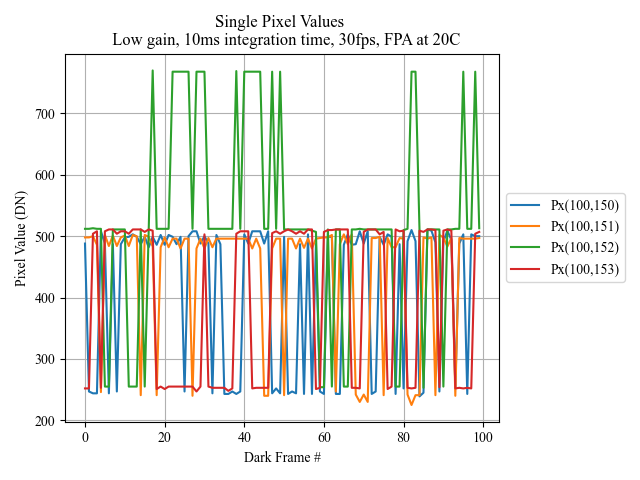

In [182]:
print(f'Mean: {np.mean(df_stack_low[1,:,:])}')
print(f'Std: {np.std(df_stack_low[1,:,:])}')
print(df_stack_low[9,100,150])
print(df_stack_low[7,300,150])

plt.figure()
# plt.plot(df_stack_low[:,100,150], label="Px(100,150)")
# plt.plot(df_stack_low[:,300,150], label="Px(300,150)")
# plt.plot(df_stack_low[:,400,150], label="Px(400,150)")
# plt.plot(df_stack_low[:,400,450], label="Px(400,450)")

plt.plot(df_stack_low[:,100,150], label="Px(100,150)")
plt.plot(df_stack_low[:,100,151], label="Px(100,151)")
plt.plot(df_stack_low[:,100,152], label="Px(100,152)")
plt.plot(df_stack_low[:,100,153], label="Px(100,153)")

# plt.plot(df_stack_low[:,400,151], label="(400,151)")
# plt.plot(df_stack_low[:,400,152], label="(400,152)")
plt.xlabel("Dark Frame #")
plt.ylabel("Pixel Value (DN)")
plt.title("Single Pixel Values \n  Low gain, 10ms integration time, 30fps, FPA at 20C")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid() 
plt.tight_layout()  # Adjust the layout